### Original: 

ideally, evan would review the material and give us the price projection he is comfortable with (he has been asking us for many pieces of analysis to lead to this question, including molly/surafael/jamies projections and now this one from adam). in the absence of his final 10G and 1G projection, i have recommended using \$ 2500 for 10G and \$ 890 for 1G.

How:
first, please review the logic for my projection. i tried to make it something that would appeal to evan. it is located here: https://docs.google.com/document/d/1R12jdZjNvhG9_4yExXCCIozwX6kZ4Axcs4dXt0y3Efk/edit?disco=AAAADU2fU3g


then calculate, for all state network states, how much would it cost to get the state 1G for all of their districts with <1,000 students, 10G for 1,000-10,000 students? for districts over 10,000 students, however many multiples of 10G get them to their goals? (evan has not requested adjustment for oversubscription, but an alternative we can try if these numbers are low are oversubscription adjustments). note that these projections may change, so it would be wise to make the cost for 1G and 10G easy to malipulate?


### New:

This is a version of state_networks_projections_1G_10G.ipynb that as flat pricing. That is, all districts, regardless if they are meeting or not meeting 1 Mbps goal will get a pricing of $890 for 1G or $2500 for 10G and how this compares to what they are already spending.

In [1]:
import math
import numpy as np
import os
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt

For all state network states, 
- how much would it cost to get the state 1G for all of their districts with <1,000 students, 10G for 1,000-10,000 students? 
- for districts over 10,000 students, however many multiples of 10G get them to their goals? (evan has not requested adjustment for oversubscription, but an alternative we can try if these numbers are low are oversubscription adjustments). 

note that these projections may change, so it would be wise to make the cost for 1G and 10G easy to malipulate?

In [2]:
# get states that are in state network
HOST_DAR = os.environ.get("HOST_DAR")
USER_DAR = os.environ.get("USER_DAR")
PASSWORD_DAR = os.environ.get("PASSWORD_DAR")
DB_DAR = os.environ.get("DB_DAR")
PORT_DAR = os.environ.get("PORT_DAR")
GITHUB = os.environ.get("GITHUB")

In [3]:
#open connection to DB
myConnection = psycopg2.connect( host=HOST_DAR, 
                                user=USER_DAR, 
                                password=PASSWORD_DAR, 
                                database=DB_DAR, 
                                port=PORT_DAR)

### QA Task 1

For all state network states,

- how much would it cost to get the state 1G for all of their districts with <1,000 students, 
- 10G for 1,000-10,000 students?

In [4]:
# sql_query_part1
sql_query = """
select 
  d.district_id, 
  d.funding_year, 
  d.name, 
  d.state_code, 
  d.consortium_affiliation,
  d.consortium_affiliation_ids,
  d.num_students, 
  dbw.ia_bw_mbps_total, 
  dbw.ia_monthly_cost_total, 
  dbw.ia_monthly_cost_per_mbps, 
  dbw.projected_bw_fy2018, 
  dbw.meeting_2018_goal_oversub, 
  dffa.fit_for_ia, 
  dffa.fit_for_ia_cost, 
  ss.sea_name, 
  ss.name as ss_name, 
  ss.state_network 
from 
  ps.districts d 
  JOIN ps.districts_bw_cost dbw on d.funding_year = dbw.funding_year 
  and d.district_id = dbw.district_id 
  join ps.districts_fit_for_analysis dffa ON d.funding_year = dffa.funding_year 
  and d.district_id = dffa.district_id 
  join ps.states_static ss on d.state_code = ss.name 
where 
  d.funding_year = 2019 
  and d.in_universe = true 
  and d.district_type = 'Traditional' 
  and ss.state_network = true
"""

#pull bandwidths from DB
cur = myConnection.cursor()
cur.execute(sql_query)
names = [x[0] for x in cur.description]
rows = cur.fetchall()
df = pd.DataFrame(rows, columns=names)

In [5]:
# convert from decimal to numeric
numeric_cols = ['num_students', 'ia_monthly_cost_total', 'ia_monthly_cost_per_mbps','projected_bw_fy2018']
df[numeric_cols] = df[numeric_cols].astype(float)

In [6]:
df.head()

,district_id,funding_year,name,state_code,consortium_affiliation,consortium_affiliation_ids,num_students,ia_bw_mbps_total,ia_monthly_cost_total,ia_monthly_cost_per_mbps,projected_bw_fy2018,meeting_2018_goal_oversub,fit_for_ia,fit_for_ia_cost,sea_name,ss_name,state_network
0,881421,2019,Marshall County School District,AL,ALABAMA SUPERCOMPUTER AUTHORITY,1005870,5687.0,2000,5284.840000,2.642420,4833.95,False,True,True,ALABAMA DEPARTMENT OF EDUCATION,AL,True
1,881423,2019,Dewitt Public School District,AR,DIS STATE OF ARKANSAS,1006162,1319.0,2000,4260.157791,2.130079,1319.00,True,True,True,ARKANSAS DEPARTMENT OF EDUCATION,AR,True
2,881427,2019,Hoover City School District,AL,ALABAMA SUPERCOMPUTER AUTHORITY,1005870,13938.0,10000,612.500000,0.061250,9756.60,True,True,True,ALABAMA DEPARTMENT OF EDUCATION,AL,True
3,881431,2019,Madison City Schools,AL,ALABAMA SUPERCOMPUTER AUTHORITY,1005870,10440.0,7500,16497.220000,2.199629,8874.00,False,True,True,ALABAMA DEPARTMENT OF EDUCATION,AL,True
4,881435,2019,Warren Public School District 1,AR,DIS STATE OF ARKANSAS,1006162,998.0,2000,3625.866167,1.812933,998.00,True,True,True,ARKANSAS DEPARTMENT OF EDUCATION,AR,True


In [42]:
df.shape

(3735, 17)

### Removing specific states with $0k state network spending: NC, AL, MS, CT, SC, WV, HI

In [44]:
df = df[~df.state_code.isin(['NC', 'AL', 'MS', 'CT', 'SC', 'WV', 'HI'])]
df.shape

(3041, 17)

In [45]:
df.state_code.unique()

array(['AR', 'DE', 'GA', 'IA', 'KY', 'ME', 'MO', 'ND', 'NE', 'RI', 'SD',
       'UT', 'WA', 'WI', 'WY'], dtype=object)

### Masks/Filters

In [46]:
mask_less_than_1k_students = df.num_students <= 1000
mask_1k_to_10k = (df.num_students > 1000) & (df.num_students <= 10000) 
mask_10k_plus = df.num_students > 10000 
mask_not_meeting = df.meeting_2018_goal_oversub == False
mask_meeting = df.meeting_2018_goal_oversub == True
mask_fit_ia = df.fit_for_ia == True
mask_fit_cost = df.fit_for_ia_cost == True

### States that can use an upgrade to 1G, Cost, and Savings

In [47]:
# number of districts  in each state
s_num_districts = df.groupby('state_code')['district_id'].count()
s_num_districts

state_code
AR    234
DE     17
GA    180
IA    330
KY    173
ME    183
MO    515
ND    174
NE    245
RI     36
SD    149
UT     41
WA    297
WI    419
WY     48
Name: district_id, dtype: int64

In [48]:
# number of districts with less than 1000 students in each state
s_1000_or_less = df[mask_less_than_1k_students].groupby('state_code')['district_id'].count()
s_1000_or_less

state_code
AR    116
GA     16
IA    208
KY     35
ME    121
MO    345
ND    161
NE    207
RI      5
SD    126
UT      6
WA    154
WI    222
WY     25
Name: district_id, dtype: int64

In [49]:
# number of districts with 1000 to <10,000 students in each state
s_1k_to_10k = df[mask_1k_to_10k].groupby('state_code')['district_id'].count()
s_1k_to_10k

state_code
AR    111
DE     12
GA    127
IA    114
KY    128
ME     62
MO    150
ND     10
NE     34
RI     29
SD     21
UT     21
WA    112
WI    189
WY     21
Name: district_id, dtype: int64

In [50]:
# number of districts with >10,000 students in each state
s_10k_plus = df[mask_10k_plus].groupby('state_code')['district_id'].count()
s_10k_plus

state_code
AR     7
DE     5
GA    37
IA     8
KY    10
MO    20
ND     3
NE     4
RI     2
SD     2
UT    14
WA    31
WI     8
WY     2
Name: district_id, dtype: int64

In [51]:
# concatenate all series into one df
df_results = pd.concat([s_num_districts, 
                        s_1000_or_less, 
                        s_1k_to_10k, 
                        s_10k_plus], axis=1, sort=True)

# rename columns
df_results.columns = ['num_districts', 
                      'num_districts_1k_or_less', 
                      'num_districts_1k_to_10k', 
                      'num_districts_10k_plus'
                     ]

# fill in nans with zeros
df_results.fillna(0, inplace=True)

In [52]:
df_results

,num_districts,num_districts_1k_or_less,num_districts_1k_to_10k,num_districts_10k_plus
AR,234,116.0,111,7.0
DE,17,0.0,12,5.0
GA,180,16.0,127,37.0
IA,330,208.0,114,8.0
KY,173,35.0,128,10.0
ME,183,121.0,62,0.0
MO,515,345.0,150,20.0
ND,174,161.0,10,3.0
NE,245,207.0,34,4.0
RI,36,5.0,29,2.0


In [53]:
# checking if 'num_districts' is equal to the sum total of 'num_districts_1k_or_less', 'num_districts_1k_to_10k',
#      'num_districts_10k_plus'
df_results['num_districts'] == df_results['num_districts_1k_or_less'] + df_results['num_districts_1k_to_10k'] + df_results['num_districts_10k_plus']



AR    True
DE    True
GA    True
IA    True
KY    True
ME    True
MO    True
ND    True
NE    True
RI    True
SD    True
UT    True
WA    True
WI    True
WY    True
dtype: bool

### QA Task 2

### QA Task 3

### Projected MRC with assumed prices for 1G, 10G

In [54]:
# change the price as needed
projected_price_1g = 890
projected_price_10g = 2500

# new mrc with $890 1G projected price
df_results['projected_mrc_1g'] = df_results['num_districts_1k_or_less']*projected_price_1g

# new mrc with $2500 per 10G projected price
df_results['projected_mrc_10g'] = df_results['num_districts_1k_to_10k']*projected_price_10g

In [55]:
df_results

,num_districts,num_districts_1k_or_less,num_districts_1k_to_10k,num_districts_10k_plus,projected_mrc_1g,projected_mrc_10g
AR,234,116.0,111,7.0,103240.0,277500
DE,17,0.0,12,5.0,0.0,30000
GA,180,16.0,127,37.0,14240.0,317500
IA,330,208.0,114,8.0,185120.0,285000
KY,173,35.0,128,10.0,31150.0,320000
ME,183,121.0,62,0.0,107690.0,155000
MO,515,345.0,150,20.0,307050.0,375000
ND,174,161.0,10,3.0,143290.0,25000
NE,245,207.0,34,4.0,184230.0,85000
RI,36,5.0,29,2.0,4450.0,72500


### Add Multiple of 10G's Needed to meet 1 Mbps Goal

In [56]:
# districts with 10k plus students
sub_cols = ['district_id', 'funding_year', 'name', 'state_code','num_students', 'ia_bw_mbps_total', 'projected_bw_fy2018']
df_10k_plus = df[sub_cols][mask_10k_plus]
df_10k_plus

,district_id,funding_year,name,state_code,num_students,ia_bw_mbps_total,projected_bw_fy2018
112,881948,2019,Bentonville Public Schools,AR,16609.0,22000,11626.30
137,882010,2019,Cabot Public School District,AR,10625.0,30000,7437.50
215,882229,2019,Fort Smith Public School,AR,14888.0,20000,10421.60
285,882469,2019,Little Rock School District,AR,23852.0,30000,16696.40
331,882690,2019,Pulaski Co Spec School District,AR,12680.0,24000,8876.00
333,882699,2019,Rogers Public School District 30,AR,15739.0,20000,11017.30
347,882764,2019,Springdale Public Schools,AR,21359.0,30000,14951.30
530,886853,2019,Appoquinimink School District,DE,10525.0,10000,8946.25
534,886859,2019,Christina School District,DE,14538.0,10000,10176.60
537,886862,2019,Indian River School District,DE,10056.0,10000,8547.60


### QA Task 4

In [57]:
# how many multiples of 10G to get them to their goals? with oversubscription
def round_up_nearest_10k(row):
    return int(math.ceil(row/10000))

# with oversubscription
df_10k_plus['multiple_10G_oversub'] = df_10k_plus.projected_bw_fy2018.apply(round_up_nearest_10k)

# without oversubscription
df_10k_plus['multiple_10G_no_oversub'] = df_10k_plus.num_students.apply(round_up_nearest_10k)

# projected cost to get 10k plus to meet 1 Mbps with oversub by district
df_10k_plus['projected_mrc_10g_10kplus_oversub'] = df_10k_plus['multiple_10G_oversub']*projected_price_10g

# projected cost to get 10k plus to meet 1 Mbps without oversub by district
df_10k_plus['projected_mrc_10g_10kplus_no_oversub'] = df_10k_plus['multiple_10G_no_oversub']*projected_price_10g

In [58]:
df_10k_plus

,district_id,funding_year,name,state_code,num_students,ia_bw_mbps_total,projected_bw_fy2018,multiple_10G_oversub,multiple_10G_no_oversub,projected_mrc_10g_10kplus_oversub,projected_mrc_10g_10kplus_no_oversub
112,881948,2019,Bentonville Public Schools,AR,16609.0,22000,11626.30,2,2,5000,5000
137,882010,2019,Cabot Public School District,AR,10625.0,30000,7437.50,1,2,2500,5000
215,882229,2019,Fort Smith Public School,AR,14888.0,20000,10421.60,2,2,5000,5000
285,882469,2019,Little Rock School District,AR,23852.0,30000,16696.40,2,3,5000,7500
331,882690,2019,Pulaski Co Spec School District,AR,12680.0,24000,8876.00,1,2,2500,5000
333,882699,2019,Rogers Public School District 30,AR,15739.0,20000,11017.30,2,2,5000,5000
347,882764,2019,Springdale Public Schools,AR,21359.0,30000,14951.30,2,3,5000,7500
530,886853,2019,Appoquinimink School District,DE,10525.0,10000,8946.25,1,2,2500,5000
534,886859,2019,Christina School District,DE,14538.0,10000,10176.60,2,2,5000,5000
537,886862,2019,Indian River School District,DE,10056.0,10000,8547.60,1,2,2500,5000


In [59]:
# total projected mrc by state for 10k plus districts
# total cost by state to upgrade districts over 10k to meeting 1 mbps with projected cost (oversub)
s_10kplus_oversub = df_10k_plus.groupby('state_code')['projected_mrc_10g_10kplus_oversub'].sum()
s_10kplus_oversub


state_code
AR     30000
DE     17500
GA    260000
IA     30000
KY     52500
MO     85000
ND      7500
NE     25000
RI      7500
SD      7500
UT    107500
WA    142500
WI     42500
WY      5000
Name: projected_mrc_10g_10kplus_oversub, dtype: int64

In [60]:
# total projected mrc by state for 10k plus districts
# total cost by state to upgrade districts over 10k to meeting 1 mbps with projected cost (no oversub)
s_10kplus_no_oversub = df_10k_plus.groupby('state_code')['projected_mrc_10g_10kplus_no_oversub'].sum()
s_10kplus_no_oversub

state_code
AR     40000
DE     25000
GA    365000
IA     45000
KY     80000
MO    107500
ND     15000
NE     37500
RI     12500
SD     12500
UT    142500
WA    195000
WI     60000
WY     10000
Name: projected_mrc_10g_10kplus_no_oversub, dtype: int64

In [61]:
# concatenate to the resultant dataframe
# concat into one resultant dataframe
df_results = pd.concat([df_results, s_10kplus_oversub, s_10kplus_no_oversub], axis=1, sort=True)

# fill in nans with zeroes
df_results.fillna(0, inplace=True)

# add total mrc - oversub
df_results['projected_mrc_total_oversub'] = df_results['projected_mrc_1g'] + df_results['projected_mrc_10g'] + df_results['projected_mrc_10g_10kplus_oversub']

# add total mrc - no oversub
df_results['projected_mrc_total_no_oversub'] = df_results['projected_mrc_1g'] + df_results['projected_mrc_10g'] + df_results['projected_mrc_10g_10kplus_no_oversub']

df_results

,num_districts,num_districts_1k_or_less,num_districts_1k_to_10k,num_districts_10k_plus,projected_mrc_1g,projected_mrc_10g,projected_mrc_10g_10kplus_oversub,projected_mrc_10g_10kplus_no_oversub,projected_mrc_total_oversub,projected_mrc_total_no_oversub
AR,234,116.0,111,7.0,103240.0,277500,30000.0,40000.0,410740.0,420740.0
DE,17,0.0,12,5.0,0.0,30000,17500.0,25000.0,47500.0,55000.0
GA,180,16.0,127,37.0,14240.0,317500,260000.0,365000.0,591740.0,696740.0
IA,330,208.0,114,8.0,185120.0,285000,30000.0,45000.0,500120.0,515120.0
KY,173,35.0,128,10.0,31150.0,320000,52500.0,80000.0,403650.0,431150.0
ME,183,121.0,62,0.0,107690.0,155000,0.0,0.0,262690.0,262690.0
MO,515,345.0,150,20.0,307050.0,375000,85000.0,107500.0,767050.0,789550.0
ND,174,161.0,10,3.0,143290.0,25000,7500.0,15000.0,175790.0,183290.0
NE,245,207.0,34,4.0,184230.0,85000,25000.0,37500.0,294230.0,306730.0
RI,36,5.0,29,2.0,4450.0,72500,7500.0,12500.0,84450.0,89450.0


### QA Task 5

### How much is the state network spending?

### For all state network states, 
- how much is the state network spending? 
- where possible, please calculate this at an application level rather than a district level. this should really just be the upstream line items serving districts in our universe, from the state network applicaiton.

In [62]:
sql_query = """
select 
  ss.state_code, 
  sum(dli.total_monthly_cost) as state_network_mrc 
  
from 
  ps.districts_line_items dli 
  JOIN ps.districts d on d.district_id = dli.district_id 
  and d.funding_year = dli.funding_year 
  join ps.states_static ss on d.state_code = ss.state_code 
  join ps.line_items li on dli.line_item_id = li.line_item_id 
  join ps.entity_bens_lkp eb on li.applicant_ben = eb.ben 
  and li.funding_year = eb.funding_year 
  
where 
  d.funding_year = 2019 
  and d.district_type = 'Traditional' 
  and d.in_universe = true 
  and ss.state_network = true 
  and dli.purpose in ('upstream') 
  and eb.entity_id in (
    1006162, 1004592, 1008357, 1009239, 
    1014118, 1015511, 1020107, 1020220, 
    1021110, 1032821, 1037707, 1035776, 
    1055594, 1051855, 1047087,
    1051850, 1049045, 1047587
  ) 
group by 
  1
"""

#pull bandwidths from DB
cur = myConnection.cursor()
cur.execute(sql_query)
names = [x[0] for x in cur.description]
rows = cur.fetchall()
df_sn_spending = pd.DataFrame(rows, columns=names)

In [63]:
# list of most common consortia ids

# 1006162

# 1004592
# 1008357
# 1009239
# 1014118
# 1015511
# 1020107
# 1016880
# 1020220
# 1021110
# 1032821
# 1037707
# 1035776
# 1055594
# 1051850 | 1051855
# 1049045
# 1047587
# 1047087

In [64]:
# set state_code as index
df_sn_spending.set_index('state_code', inplace=True)
df_sn_spending

,state_network_mrc
state_code,
AR,728168.3366666667000000000000000000000
DE,133676.99999999999999988435
GA,352006.3300000000000038376521
IA,116073.3599999999999992694061
KY,890919.2999999999999678872284
ME,150805.1399999999999975070834
MO,462652.22999999999700001600000000000000
ND,141962.6392210144927486187349
NE,128618.7000000000000000000000


In [65]:
# merge dataframes
df_final = pd.concat([df_results, df_sn_spending], axis=1, sort=True)

# fill in nan's with zeros
df_final.fillna(0, inplace=True)

### Add pretty print for plotting

In [66]:
# format thousands as string
df_final['projected_mrc_total_oversub_pp'] = (df_final['projected_mrc_total_oversub']/1000).apply(lambda x: '{:,.0f}k'.format(x))
df_final['state_network_mrc_pp'] = (df_final['state_network_mrc']/1000).apply(lambda x: '{:,.0f}k'.format(x))
df_final['projected_mrc_total_no_oversub_pp'] = (df_final['projected_mrc_total_no_oversub']/1000).apply(lambda x: '{:,.0f}k'.format(x))



In [67]:
df_final

,num_districts,num_districts_1k_or_less,num_districts_1k_to_10k,num_districts_10k_plus,projected_mrc_1g,projected_mrc_10g,projected_mrc_10g_10kplus_oversub,projected_mrc_10g_10kplus_no_oversub,projected_mrc_total_oversub,projected_mrc_total_no_oversub,state_network_mrc,projected_mrc_total_oversub_pp,state_network_mrc_pp,projected_mrc_total_no_oversub_pp
state_code,,,,,,,,,,,,,,
AR,234,116.0,111,7.0,103240.0,277500,30000.0,40000.0,410740.0,420740.0,728168.3366666667000000000000000000000,411k,728k,421k
DE,17,0.0,12,5.0,0.0,30000,17500.0,25000.0,47500.0,55000.0,133676.99999999999999988435,48k,134k,55k
GA,180,16.0,127,37.0,14240.0,317500,260000.0,365000.0,591740.0,696740.0,352006.3300000000000038376521,592k,352k,697k
IA,330,208.0,114,8.0,185120.0,285000,30000.0,45000.0,500120.0,515120.0,116073.3599999999999992694061,500k,116k,515k
KY,173,35.0,128,10.0,31150.0,320000,52500.0,80000.0,403650.0,431150.0,890919.2999999999999678872284,404k,891k,431k
ME,183,121.0,62,0.0,107690.0,155000,0.0,0.0,262690.0,262690.0,150805.1399999999999975070834,263k,151k,263k
MO,515,345.0,150,20.0,307050.0,375000,85000.0,107500.0,767050.0,789550.0,462652.22999999999700001600000000000000,767k,463k,790k
ND,174,161.0,10,3.0,143290.0,25000,7500.0,15000.0,175790.0,183290.0,141962.6392210144927486187349,176k,142k,183k
NE,245,207.0,34,4.0,184230.0,85000,25000.0,37500.0,294230.0,306730.0,128618.7000000000000000000000,294k,129k,307k


### QA Task 6

### Already spending?

In [68]:
# already spending column (oversub)
df_final['already_spending_oversub'] = df_final.state_network_mrc >= df_final.projected_mrc_total_oversub

# already spending column (no oversub)
df_final['already_spending_no_oversub'] = df_final.state_network_mrc >= df_final.projected_mrc_total_no_oversub

In [69]:
df_final

,num_districts,num_districts_1k_or_less,num_districts_1k_to_10k,num_districts_10k_plus,projected_mrc_1g,projected_mrc_10g,projected_mrc_10g_10kplus_oversub,projected_mrc_10g_10kplus_no_oversub,projected_mrc_total_oversub,projected_mrc_total_no_oversub,state_network_mrc,projected_mrc_total_oversub_pp,state_network_mrc_pp,projected_mrc_total_no_oversub_pp,already_spending_oversub,already_spending_no_oversub
state_code,,,,,,,,,,,,,,,,
AR,234,116.0,111,7.0,103240.0,277500,30000.0,40000.0,410740.0,420740.0,728168.3366666667000000000000000000000,411k,728k,421k,True,True
DE,17,0.0,12,5.0,0.0,30000,17500.0,25000.0,47500.0,55000.0,133676.99999999999999988435,48k,134k,55k,True,True
GA,180,16.0,127,37.0,14240.0,317500,260000.0,365000.0,591740.0,696740.0,352006.3300000000000038376521,592k,352k,697k,False,False
IA,330,208.0,114,8.0,185120.0,285000,30000.0,45000.0,500120.0,515120.0,116073.3599999999999992694061,500k,116k,515k,False,False
KY,173,35.0,128,10.0,31150.0,320000,52500.0,80000.0,403650.0,431150.0,890919.2999999999999678872284,404k,891k,431k,True,True
ME,183,121.0,62,0.0,107690.0,155000,0.0,0.0,262690.0,262690.0,150805.1399999999999975070834,263k,151k,263k,False,False
MO,515,345.0,150,20.0,307050.0,375000,85000.0,107500.0,767050.0,789550.0,462652.22999999999700001600000000000000,767k,463k,790k,False,False
ND,174,161.0,10,3.0,143290.0,25000,7500.0,15000.0,175790.0,183290.0,141962.6392210144927486187349,176k,142k,183k,False,False
NE,245,207.0,34,4.0,184230.0,85000,25000.0,37500.0,294230.0,306730.0,128618.7000000000000000000000,294k,129k,307k,False,False


### Conclusion

In [70]:
print(f"Number of states in state network already spending enough to get ALL districts to upgrade to 1G or 10G (oversub): \
{df_final.already_spending_oversub.sum()} out of {df_final.shape[0]}")

Number of states in state network already spending enough to get ALL districts to upgrade to 1G or 10G (oversub): 7 out of 15


In [71]:
print(f"Number of states in state network already spending enough to get ALL districts to upgrade to 1G or 10G (oversub): \
{df_final.already_spending_no_oversub.sum()} out of {df_final.shape[0]}")


Number of states in state network already spending enough to get ALL districts to upgrade to 1G or 10G (oversub): 6 out of 15


### QA Task 7

### Plotting

In [72]:
df_final

,num_districts,num_districts_1k_or_less,num_districts_1k_to_10k,num_districts_10k_plus,projected_mrc_1g,projected_mrc_10g,projected_mrc_10g_10kplus_oversub,projected_mrc_10g_10kplus_no_oversub,projected_mrc_total_oversub,projected_mrc_total_no_oversub,state_network_mrc,projected_mrc_total_oversub_pp,state_network_mrc_pp,projected_mrc_total_no_oversub_pp,already_spending_oversub,already_spending_no_oversub
state_code,,,,,,,,,,,,,,,,
AR,234,116.0,111,7.0,103240.0,277500,30000.0,40000.0,410740.0,420740.0,728168.3366666667000000000000000000000,411k,728k,421k,True,True
DE,17,0.0,12,5.0,0.0,30000,17500.0,25000.0,47500.0,55000.0,133676.99999999999999988435,48k,134k,55k,True,True
GA,180,16.0,127,37.0,14240.0,317500,260000.0,365000.0,591740.0,696740.0,352006.3300000000000038376521,592k,352k,697k,False,False
IA,330,208.0,114,8.0,185120.0,285000,30000.0,45000.0,500120.0,515120.0,116073.3599999999999992694061,500k,116k,515k,False,False
KY,173,35.0,128,10.0,31150.0,320000,52500.0,80000.0,403650.0,431150.0,890919.2999999999999678872284,404k,891k,431k,True,True
ME,183,121.0,62,0.0,107690.0,155000,0.0,0.0,262690.0,262690.0,150805.1399999999999975070834,263k,151k,263k,False,False
MO,515,345.0,150,20.0,307050.0,375000,85000.0,107500.0,767050.0,789550.0,462652.22999999999700001600000000000000,767k,463k,790k,False,False
ND,174,161.0,10,3.0,143290.0,25000,7500.0,15000.0,175790.0,183290.0,141962.6392210144927486187349,176k,142k,183k,False,False
NE,245,207.0,34,4.0,184230.0,85000,25000.0,37500.0,294230.0,306730.0,128618.7000000000000000000000,294k,129k,307k,False,False


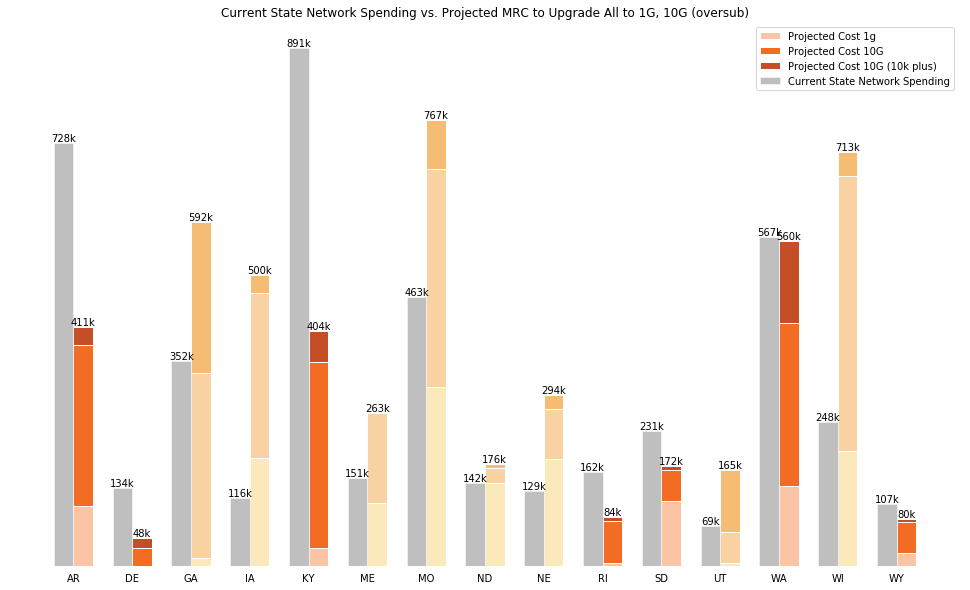

In [84]:
# indices where bar plot will go
xmarks = np.arange(0, len(df_final.index))

fig = plt.figure(figsize=(17, 10))
ax = fig.add_subplot(111)
width = np.min(np.diff(xmarks))/3

proj_cost_col = 'projected_mrc_total_oversub'
orig_cost_col = 'state_network_mrc'
df_input = df_final.copy()

# customize colors
colors_1g = []
colors_10g = []
colors_10g_plus = []
for orig_cost, proj_cost in zip(df_input[orig_cost_col], df_input[proj_cost_col]): 
    if orig_cost >= proj_cost:
        colors_1g.append('#fac4a5')
        colors_10g.append('#f26c23')
        colors_10g_plus.append('#c44f27')
    else:
        colors_1g.append('#fbe9bc')
        colors_10g.append('#f9d2a3')
        colors_10g_plus.append('#f5bc74')


ax.bar(xmarks+width/2., df_final.projected_mrc_1g, width, color=colors_1g, edgecolor='white', label='Projected Cost 1g')
ax.bar(xmarks+width/2., df_final.projected_mrc_10g, width, bottom=df_final.projected_mrc_1g, color=colors_10g, edgecolor='white', label='Projected Cost 10G')
ax.bar(xmarks+width/2., df_final.projected_mrc_10g_10kplus_oversub, width, bottom=df_final.projected_mrc_1g+df_final.projected_mrc_10g, color=colors_10g_plus, edgecolor='white', label='Projected Cost 10G (10k plus)')
ax.bar(xmarks-width/2., df_final.state_network_mrc, width, color='grey', edgecolor='white', label='Current State Network Spending', alpha=.5)

plt.xticks(xmarks, df_final.index)
plt.title("Current State Network Spending vs. Projected MRC to Upgrade All to 1G, 10G (oversub)")
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=True)
plt.box(None)
plt.legend()

# add sum labels
for x0, x1, v0, v1, label_proj, label_sn in zip(xmarks+width/2, xmarks-width/2, 
                                            df_final['projected_mrc_total_oversub'], df_final['state_network_mrc'],
                                            df_final['projected_mrc_total_oversub_pp'], df_final['state_network_mrc_pp']):
    plt.text(x0, v0, label_proj, ha='center', va='bottom')
    plt.text(x1, v1, label_sn, ha='center', va='bottom')

#plt.savefig("filename.png", bbox_inches = 'tight')
plt.show()


### Version 2 plot: sorted, oversub

In [74]:
# reset and rename column
df_final_v2 = df_final.reset_index()
df_final_v2.columns = ['state_code','num_districts', 'num_districts_1k_or_less', 'num_districts_1k_to_10k',
       'num_districts_10k_plus', 'projected_mrc_1g', 'projected_mrc_10g',
       'projected_mrc_10g_10kplus_oversub',
       'projected_mrc_10g_10kplus_no_oversub', 'projected_mrc_total_oversub',
       'projected_mrc_total_no_oversub', 'state_network_mrc',
       'projected_mrc_total_oversub_pp', 'state_network_mrc_pp',
       'projected_mrc_total_no_oversub_pp', 'already_spending_oversub',
       'already_spending_no_oversub']

# sort values
df_final_v2 = df_final_v2.sort_values('projected_mrc_total_oversub', ascending=False)

In [75]:
df_final_v2

,state_code,num_districts,num_districts_1k_or_less,num_districts_1k_to_10k,num_districts_10k_plus,projected_mrc_1g,projected_mrc_10g,projected_mrc_10g_10kplus_oversub,projected_mrc_10g_10kplus_no_oversub,projected_mrc_total_oversub,projected_mrc_total_no_oversub,state_network_mrc,projected_mrc_total_oversub_pp,state_network_mrc_pp,projected_mrc_total_no_oversub_pp,already_spending_oversub,already_spending_no_oversub
6,MO,515,345.0,150,20.0,307050.0,375000,85000.0,107500.0,767050.0,789550.0,462652.22999999999700001600000000000000,767k,463k,790k,False,False
13,WI,419,222.0,189,8.0,197580.0,472500,42500.0,60000.0,712580.0,730080.0,247789.3200000000000000000000,713k,248k,730k,False,False
2,GA,180,16.0,127,37.0,14240.0,317500,260000.0,365000.0,591740.0,696740.0,352006.3300000000000038376521,592k,352k,697k,False,False
12,WA,297,154.0,112,31.0,137060.0,280000,142500.0,195000.0,559560.0,612060.0,566671.1308333333400000000000000000000,560k,567k,612k,True,False
3,IA,330,208.0,114,8.0,185120.0,285000,30000.0,45000.0,500120.0,515120.0,116073.3599999999999992694061,500k,116k,515k,False,False
0,AR,234,116.0,111,7.0,103240.0,277500,30000.0,40000.0,410740.0,420740.0,728168.3366666667000000000000000000000,411k,728k,421k,True,True
4,KY,173,35.0,128,10.0,31150.0,320000,52500.0,80000.0,403650.0,431150.0,890919.2999999999999678872284,404k,891k,431k,True,True
8,NE,245,207.0,34,4.0,184230.0,85000,25000.0,37500.0,294230.0,306730.0,128618.7000000000000000000000,294k,129k,307k,False,False
5,ME,183,121.0,62,0.0,107690.0,155000,0.0,0.0,262690.0,262690.0,150805.1399999999999975070834,263k,151k,263k,False,False
7,ND,174,161.0,10,3.0,143290.0,25000,7500.0,15000.0,175790.0,183290.0,141962.6392210144927486187349,176k,142k,183k,False,False


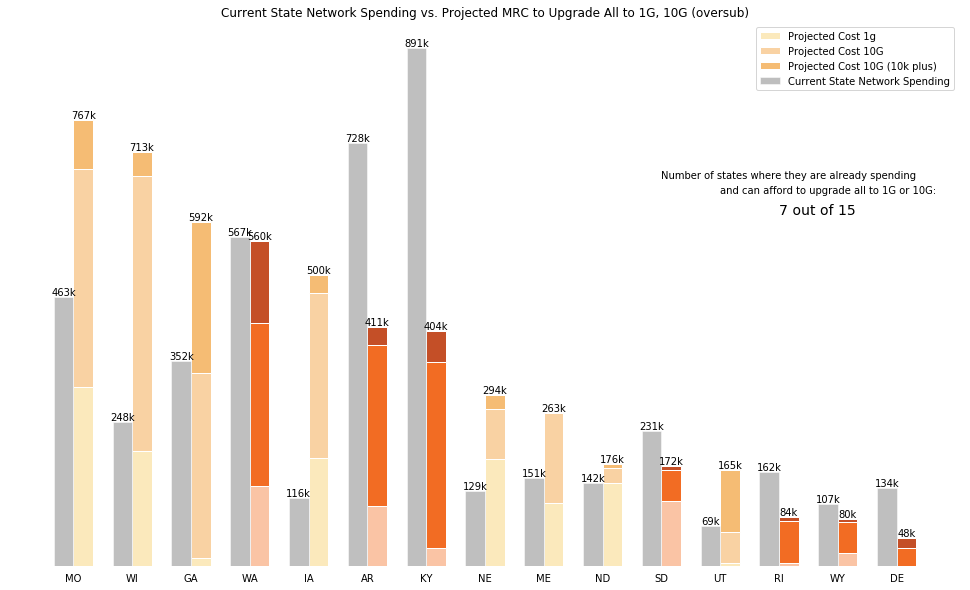

In [83]:
# indices where bar plot will go
xmarks = np.arange(0, len(df_final_v2.index))

fig = plt.figure(figsize=(17, 10))
ax = fig.add_subplot(111)
width = np.min(np.diff(xmarks))/3

proj_cost_col = 'projected_mrc_total_oversub'
orig_cost_col = 'state_network_mrc'
df_input = df_final_v2.copy()

# customize colors
colors_1g = []
colors_10g = []
colors_10g_plus = []
for orig_cost, proj_cost in zip(df_input[orig_cost_col], df_input[proj_cost_col]): 
    if orig_cost >= proj_cost:
        colors_1g.append('#fac4a5')
        colors_10g.append('#f26c23')
        colors_10g_plus.append('#c44f27')
    else:
        colors_1g.append('#fbe9bc')
        colors_10g.append('#f9d2a3')
        colors_10g_plus.append('#f5bc74')

ax.bar(xmarks+width/2., df_final_v2.projected_mrc_1g, width, color=colors_1g, edgecolor='white', label='Projected Cost 1g')
ax.bar(xmarks+width/2., df_final_v2.projected_mrc_10g, width, bottom=df_final_v2.projected_mrc_1g, color=colors_10g, edgecolor='white', label='Projected Cost 10G')
ax.bar(xmarks+width/2., df_final_v2.projected_mrc_10g_10kplus_oversub, width, bottom=df_final_v2.projected_mrc_1g+df_final_v2.projected_mrc_10g, color=colors_10g_plus, edgecolor='white', label='Projected Cost 10G (10k plus)')
ax.bar(xmarks-width/2., df_final_v2.state_network_mrc, width, color='grey', edgecolor='white', label='Current State Network Spending', alpha=.5)

plt.xticks(xmarks, df_final_v2.state_code)
plt.title("Current State Network Spending vs. Projected MRC to Upgrade All to 1G, 10G (oversub)")
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=True)
plt.box(None)
plt.legend()

# add sum labels
for x0, x1, v0, v1, label_proj, label_sn in zip(xmarks+width/2, xmarks-width/2, 
                                            df_final_v2['projected_mrc_total_oversub'], df_final_v2['state_network_mrc'],
                                            df_final_v2['projected_mrc_total_oversub_pp'], df_final_v2['state_network_mrc_pp']):
    plt.text(x0, v0, label_proj, ha='center', va='bottom')
    plt.text(x1, v1, label_sn, ha='center', va='bottom')

    
# conclusion texts
plt.text(10, .75*int((max(df_final_v2.state_network_mrc))), "Number of states where they are already spending ")
plt.text(11, .72*int((max(df_final_v2.state_network_mrc))), "and can afford to upgrade all to 1G or 10G: ")
plt.text(12, .68*int((max(df_final_v2.state_network_mrc))), str(df_final_v2.already_spending_oversub.sum()) + " out of " + str(df_final_v2.shape[0]), fontsize=14)

#plt.savefig("filename.png", bbox_inches = 'tight')
plt.show()


### Version 3 plot: sorted, no oversub

In [85]:
df_final_v3.columns

Index(['state_code', 'num_districts', 'num_districts_1k_or_less',
       'num_districts_1k_to_10k', 'num_districts_10k_plus', 'projected_mrc_1g',
       'projected_mrc_10g', 'projected_mrc_10g_10kplus_oversub',
       'projected_mrc_10g_10kplus_no_oversub', 'projected_mrc_total_oversub',
       'projected_mrc_total_no_oversub', 'state_network_mrc',
       'projected_mrc_total_oversub_pp', 'state_network_mrc_pp',
       'projected_mrc_total_no_oversub_pp', 'already_spending_oversub',
       'already_spending_no_oversub'],
      dtype='object')

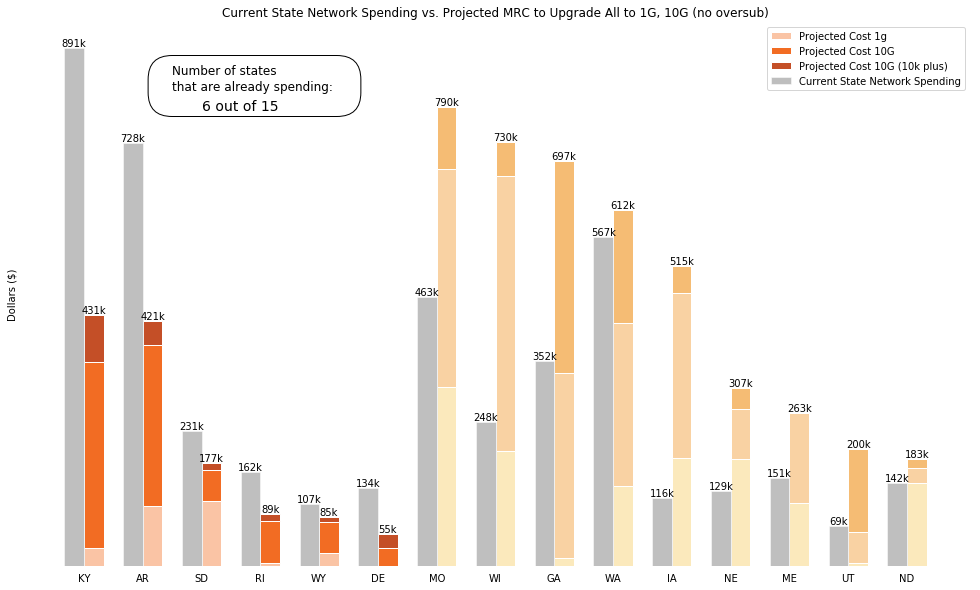

In [107]:
# reset and rename column
df_final_v3 = df_final.reset_index()
df_final_v3.columns = ['state_code','num_districts', 'num_districts_1k_or_less', 'num_districts_1k_to_10k',
       'num_districts_10k_plus', 'projected_mrc_1g', 'projected_mrc_10g',
       'projected_mrc_10g_10kplus_oversub',
       'projected_mrc_10g_10kplus_no_oversub', 'projected_mrc_total_oversub',
       'projected_mrc_total_no_oversub', 'state_network_mrc',
       'projected_mrc_total_oversub_pp', 'state_network_mrc_pp',
       'projected_mrc_total_no_oversub_pp', 'already_spending_oversub',
       'already_spending_no_oversub']

# sort values
proj_cost_col = 'projected_mrc_total_no_oversub'
orig_cost_col = 'state_network_mrc'
df_final_v3 = df_final_v3.sort_values(['already_spending_no_oversub', proj_cost_col], ascending=False)
df_input = df_final_v3.copy()

# customize colors
colors_1g = []
colors_10g = []
colors_10g_plus = []
for orig_cost, proj_cost in zip(df_input[orig_cost_col], df_input[proj_cost_col]): 
    if orig_cost >= proj_cost:
        colors_1g.append('#fac4a5')
        colors_10g.append('#f26c23')
        colors_10g_plus.append('#c44f27')
    else:
        colors_1g.append('#fbe9bc')
        colors_10g.append('#f9d2a3')
        colors_10g_plus.append('#f5bc74')

# indices where bar plot will go
xmarks = np.arange(0, len(df_final_v3.index))

fig = plt.figure(figsize=(17, 10))
ax = fig.add_subplot(111)
width = np.min(np.diff(xmarks))/3

ax.bar(xmarks+width/2., df_final_v3.projected_mrc_1g, width, color=colors_1g, edgecolor='white', label='Projected Cost 1g')
ax.bar(xmarks+width/2., df_final_v3.projected_mrc_10g, width, bottom=df_final_v3.projected_mrc_1g, color=colors_10g, edgecolor='white', label='Projected Cost 10G')
ax.bar(xmarks+width/2., df_final_v3.projected_mrc_10g_10kplus_no_oversub, width, bottom=df_final_v3.projected_mrc_1g+df_final_v3.projected_mrc_10g, color=colors_10g_plus, edgecolor='white', label='Projected Cost 10G (10k plus)')
ax.bar(xmarks-width/2., df_final_v3.state_network_mrc, width, color='grey', edgecolor='white', label='Current State Network Spending', alpha=.5)

plt.xticks(xmarks, df_final_v3.state_code)
plt.title("Current State Network Spending vs. Projected MRC to Upgrade All to 1G, 10G (no oversub)")
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=True)
plt.ylabel("Dollars ($)")
plt.box(None)
plt.legend()

# add sum labels
for x0, x1, v0, v1, label_proj, label_sn in zip(xmarks+width/2, xmarks-width/2, 
                                            df_final_v3['projected_mrc_total_no_oversub'], df_final_v3['state_network_mrc'],
                                            df_final_v3['projected_mrc_total_no_oversub_pp'], df_final_v3['state_network_mrc_pp']):
    plt.text(x0, v0, label_proj, ha='center', va='bottom')
    plt.text(x1, v1, label_sn, ha='center', va='bottom')

    
# conclusion texts
plt.text(1.5, .95*int((max(df_final_v3.state_network_mrc))), "Number of states  ", fontsize=12)
plt.text(1.5, .92*int((max(df_final_v3.state_network_mrc))), "that are already spending: ", fontsize=12, color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=2'))
plt.text(2, .88*int((max(df_final_v3.state_network_mrc))), str(df_final_v3.already_spending_no_oversub.sum()) + " out of " + str(df_final_v3.shape[0]), fontsize=14)

# save to isl folder figure_images
os.chdir(GITHUB + '/Projects/sots-isl/figure_images/')
plt.savefig("id6005_state_networks_projections_1G_10G_flat_pricing.png", bbox_inches = 'tight')
plt.show()


In [108]:
# converting to a .py file
# !jupyter nbconvert --to script state_networks_projections_1G_10G_flat_pricing.ipynb

[NbConvertApp] Converting notebook state_networks_projections_1G_10G_flat_pricing.ipynb to script
[NbConvertApp] Writing 21650 bytes to state_networks_projections_1G_10G_flat_pricing.py
